# 01 – Smart-Grid Data Overview

Quick-look analytics for interim and processed datasets (clean + augmented) plus optional PED2-derived features.

## Objectives
- Confirm ingestion outputs retain the expected feature count, timeline density, and label coverage.
- Compare interim vs cleaned/augmented versions to see how preprocessing shifts summary statistics.
- Visualize correlations, time-series windows, and synthetic fault behavior before feeding models.

In [2]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

# Resolve project root so we can import local modules when running from JupyterLab
CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
for candidate in CANDIDATES:
    if (candidate / "README.md").exists():
        PROJECT_ROOT = candidate.resolve()
        break
else:
    raise RuntimeError("Run this notebook from inside the repository (README.md not found).")

if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
CONFIGS = PROJECT_ROOT / "configs"
print(f"Project root: {PROJECT_ROOT}")
print(f"Interim data dir: {DATA_INTERIM}")
print(f"Processed data dir: {DATA_PROCESSED}")

Project root: /Users/tamaghnachoudhuri/Desktop/Projects/daa
Interim data dir: /Users/tamaghnachoudhuri/Desktop/Projects/daa/data/interim
Processed data dir: /Users/tamaghnachoudhuri/Desktop/Projects/daa/data/processed


In [3]:
from smart_grid_fault_detection.data_prep import load_manifest

manifest_path = CONFIGS / "data_manifest.yaml"
if not manifest_path.exists():
    manifest_path = CONFIGS / "data_manifest.example.yaml"
    print("Using example manifest – update configs/data_manifest.yaml for production experiments.")

manifest = load_manifest(manifest_path)
manifest

DatasetManifest(sources=[SourceConfig(name='synthetic_smart_grid', path=PosixPath('data/raw/smart_grid_signals.csv'), format='csv', timestamp_col='timestamp', timezone='UTC', frequency='15min', features=['load_mw', 'voltage_kv', 'frequency_hz', 'solar_mw', 'wind_mw', 'hydro_mw', 'thermal_mw', 'reactive_power_mvar', 'power_factor', 'demand_forecast_mw', 'import_mw', 'export_mw', 'line_temp_c', 'transformer_load_pct', 'substation_pressure_kpa', 'frequency_setpoint_hz', 'frequency_error_mhz', 'var_comp_alert', 'humidity_pct', 'ambient_temp_c', 'wind_speed_ms', 'irradiance_wm2', 'barometric_kpa', 'rainfall_mm', 'pmu_angle_deg', 'pmu_magnitude', 'battery_soc_pct', 'ev_charging_kw', 'grid_loss_pct', 'cyber_signal_offset', 'fault_type', 'fault_flag'], dtypes=None, null_markers=['', 'NA', 'NaN'])], output=OutputConfig(interim_table=PosixPath('data/interim/smart_grid_master.parquet'), schema_report=PosixPath('docs/smart_grid_schema.md')), merge_strategy='outer', sort_timestamps=True)

In [4]:
INTERIM_PATH = manifest.output.interim_table
PROCESSED_PATH = DATA_PROCESSED / "smart_grid_clean.parquet"
AUGMENTED_PATH = DATA_PROCESSED / "smart_grid_augmented.parquet"

frames = {}
for label, path in {
    "interim": INTERIM_PATH,
    "clean": PROCESSED_PATH,
    "augmented": AUGMENTED_PATH,
}.items():
    if path.exists():
        frames[label] = pd.read_parquet(path)
        print(f"Loaded {label} frame from {path} -> {len(frames[label]):,} rows, {frames[label].shape[1]} columns")
    else:
        print(f"[warning] {label} path missing: {path}")

frames.keys()

[warning] interim path missing: data/interim/smart_grid_master.parquet
Loaded clean frame from /Users/tamaghnachoudhuri/Desktop/Projects/daa/data/processed/smart_grid_clean.parquet -> 1,344 rows, 33 columns
Loaded augmented frame from /Users/tamaghnachoudhuri/Desktop/Projects/daa/data/processed/smart_grid_augmented.parquet -> 1,344 rows, 33 columns


dict_keys(['clean', 'augmented'])

In [5]:
def summarize(df: pd.DataFrame, label: str) -> pd.DataFrame:
    summary = pd.DataFrame(
        {
            "rows": [len(df)],
            "start": [df["timestamp"].min()],
            "end": [df["timestamp"].max()],
            "fault_rate": [df.get("fault_flag", pd.Series([0])).mean()],
            "features": [len(df.columns)],
        }
    )
    summary.index = [label]
    return summary

summary_tables = []
for label, df in frames.items():
    summary_tables.append(summarize(df, label))

if summary_tables:
    display(pd.concat(summary_tables))
else:
    print("No frames loaded – rerun ingestion/processing first.")

,rows,start,end,fault_rate,features
clean,1344,2024-01-01 00:00:00+00:00,2024-01-14 23:45:00+00:00,0.102679,33
augmented,1344,2024-01-01 00:00:00+00:00,2024-01-14 23:45:00+00:00,0.521577,33


In [6]:
if "interim" in frames:
    display(frames["interim"].describe().T)

if "clean" in frames:
    display(frames["clean"].describe().T)

,count,mean,std,min,25%,50%,75%,max
load_mw,1344.0,548.493369,106.638733,167.886753,473.774548,5.540228e+02,631.137868,925.287647
voltage_kv,1344.0,231.058537,4.683172,210.950881,230.445026,2.314366e+02,233.441340,236.552478
frequency_hz,1344.0,50.000864,0.028121,49.899137,49.985586,5.000018e+01,50.014646,50.102595
solar_mw,1344.0,47.332000,58.503580,-30.476326,0.060707,1.428271e+01,104.359621,173.154055
wind_mw,1344.0,80.188427,22.862794,12.929079,62.507220,8.020467e+01,97.172711,150.041114
hydro_mw,1344.0,119.957734,5.009326,104.281668,116.549937,1.199886e+02,123.057563,137.270232
thermal_mw,1344.0,401.286929,41.002397,224.435417,374.818437,4.002100e+02,428.811459,528.326437
reactive_power_mvar,1344.0,191.678338,34.703669,101.247280,165.035006,1.896796e+02,219.293052,280.065928
power_factor,1344.0,0.951664,0.006941,0.933987,0.946141,9.520641e-01,0.956993,0.969751
demand_forecast_mw,1344.0,549.613499,89.745590,321.460331,471.159796,5.461843e+02,627.860793,746.864918


In [7]:
if "clean" in frames:
    faults = frames["clean"].groupby("fault_type").size().sort_values(ascending=False)
    display(faults.to_frame(name="count"))
else:
    print("Clean dataframe missing – cannot compute fault distribution.")

,count
fault_type,
normal,1206
cyber,72
spike,36
dropout,30


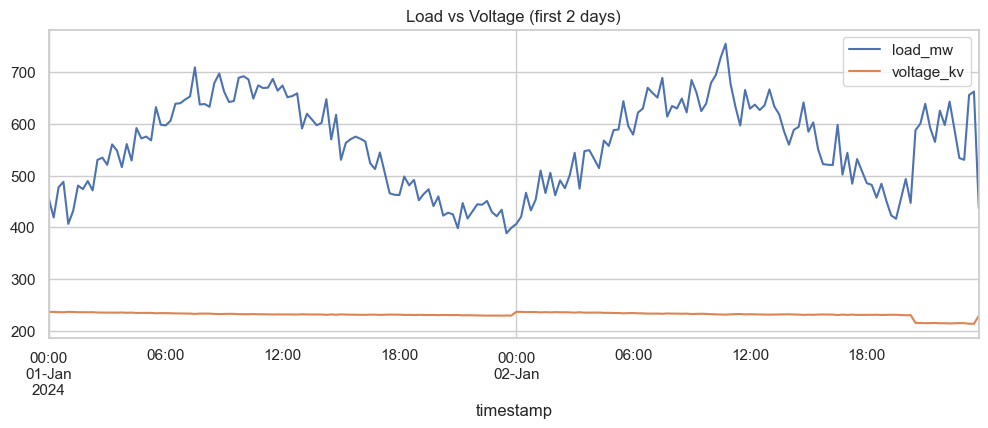

In [8]:
if "clean" in frames:
    subset = frames["clean"][
        ["timestamp", "load_mw", "voltage_kv", "frequency_hz", "fault_flag"]
    ].set_index("timestamp").sort_index()
    window = subset.iloc[: 96 * 2]
    ax = window[["load_mw", "voltage_kv"]].plot(subplots=False, figsize=(12, 4))
    ax.set_title("Load vs Voltage (first 2 days)")
    plt.show()
else:
    print("Clean dataframe missing – skip timeline plot.")

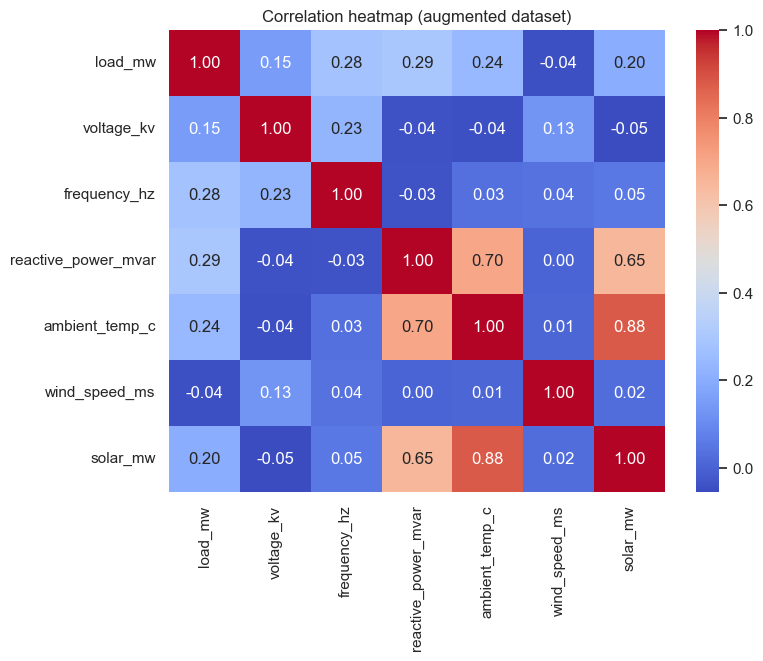

In [9]:
if "augmented" in frames:
    aug = frames["augmented"]
    corr_cols = [
        "load_mw",
        "voltage_kv",
        "frequency_hz",
        "reactive_power_mvar",
        "ambient_temp_c",
        "wind_speed_ms",
        "solar_mw",
    ]
    corr = aug[corr_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation heatmap (augmented dataset)")
    plt.show()
else:
    print("Augmented dataframe missing – skip correlation heatmap.")

In [10]:
PED2_PATH = DATA_INTERIM / "ped2_training_features.parquet"
if PED2_PATH.exists():
    ped2 = pd.read_parquet(PED2_PATH)
    ped2.describe()[["grad_mean", "frame_absdiff_mean"]]
else:
    print("PED2 feature parquet not found – run ped2_converter first.")

PED2 feature parquet not found – run ped2_converter first.


/var/folders/zg/zw15w2v51ds9djsgbll1sm080000gn/T/ipykernel_60387/3515876962.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  window = aug.set_index("timestamp")["fault_flag"].resample("6H").mean()


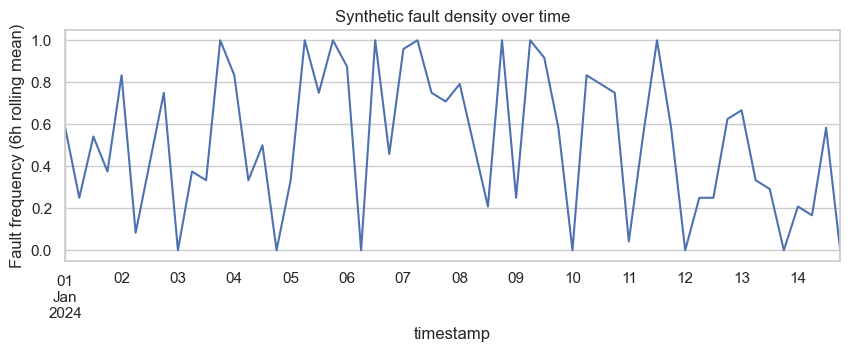

In [11]:
if "augmented" in frames:
    aug = frames["augmented"].copy()
    aug["timestamp"] = pd.to_datetime(aug["timestamp"])
    window = aug.set_index("timestamp")["fault_flag"].resample("6H").mean()
    plt.figure(figsize=(10, 3))
    window.plot()
    plt.ylabel("Fault frequency (6h rolling mean)")
    plt.title("Synthetic fault density over time")
    plt.show()

## Next Steps
- Layer PCA or autoencoder latent projections on top of the cleaned dataframe and append the plots here.
- Export summary tables/figures to `reports/figures/` for inclusion in status updates.
- Repeat the analysis after ingesting real SCADA/PMU streams to quantify differences vs the synthetic baseline.